In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TF version: 2.15.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras import layers, Sequential

In [3]:
# !mkdir -p ./data/
# # Download the dataset and store the tar.gz file in Google Drive
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ./data/cifar-10-python.tar.gz

# # Extract the dataset in the home directory (/content/)
# !tar -xzf ./data/cifar-10-python.tar.gz -C ./data/

In [4]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Define the path to the extracted dataset
cifar10_dir = './data/cifar-10-batches-py'

# Load the data batches
data_batches = []
labels = []

for i in range(1, 6):
    batch_path = os.path.join(cifar10_dir, f'data_batch_{i}')
    batch_data = unpickle(batch_path)
    data_batches.append(batch_data[b'data'])
    labels.extend(batch_data[b'labels'])

# Load the test batch
test_batch_path = os.path.join(cifar10_dir, 'test_batch')
test_batch_data = unpickle(test_batch_path)
test_data = test_batch_data[b'data']
test_labels = test_batch_data[b'labels']

# Load the labels
label_names_path = os.path.join(cifar10_dir, 'batches.meta')
label_names = unpickle(label_names_path)[b'label_names']

# Concatenate the training data and labels
train_data = np.concatenate(data_batches)
train_labels = np.array(labels)
test_labels = np.array(test_labels)

In [5]:
print("all the lables names: ", label_names)
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Reshaped training data shape:", train_data.shape)
print("Reshaped test data shape:", test_data.shape)

all the lables names:  [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)
Reshaped training data shape: (50000, 32, 32, 3)
Reshaped test data shape: (10000, 32, 32, 3)


[11561 43579 38230   194 26881 39329 33954   110 15522  1075]


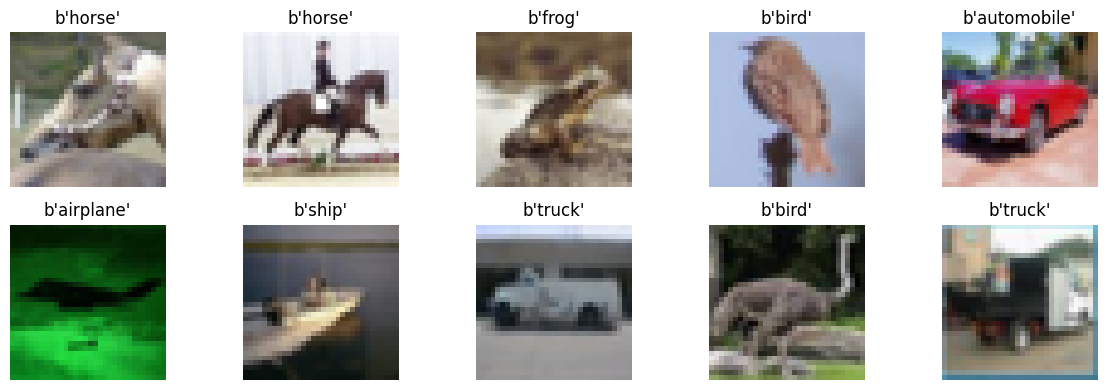

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a few random indices
num_images = 10
indices = np.random.choice(len(train_data), num_images, replace=False)
print(indices)
# Plot the selected images
plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_data[idx])
    plt.title(label_names[train_labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    .shuffle(10000)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_data, test_labels))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("Pipeline ready")


Pipeline ready


In [8]:
VGG11 = Sequential([
    layers.Input(shape=(32, 32, 3)),  
    layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
     
    layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4096, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1000, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax")
])

VGG11.compile(
    optimizer=tf.keras.optimizers.legacy.SGD(
        learning_rate=0.01,
        momentum=0.9,
        decay=5e-4
    ),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

VGG11.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         5

In [9]:
history = VGG11.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10


782/782 [==============================] - 7s 7ms/step - loss: 2.1964 - accuracy: 0.1532 - val_loss: 1.9838 - val_accuracy: 0.2287
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 1.8077 - accuracy: 0.2882 - val_loss: 1.6779 - val_accuracy: 0.3455
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 1.5439 - accuracy: 0.4093 - val_loss: 1.3580 - val_accuracy: 0.4976
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 1.2856 - accuracy: 0.5237 - val_loss: 1.1690 - val_accuracy: 0.5733
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 1.0923 - accuracy: 0.6040 - val_loss: 1.0644 - val_accuracy: 0.6155
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9428 - accuracy: 0.6638 - val_loss: 1.0093 - val_accuracy: 0.6437
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.8185 - accuracy: 0.7075 - val_loss: 0.9971 - val_accuracy: 0.6634
Epoch 8/10
782/78

In [10]:
def plot_history(history):
  # Get accuracy and loss from history
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']
  train_loss = history['loss']
  val_loss = history['val_loss']

  epochs_range = range(len(train_acc))

  # Plot Training and Validation Accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Plot Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

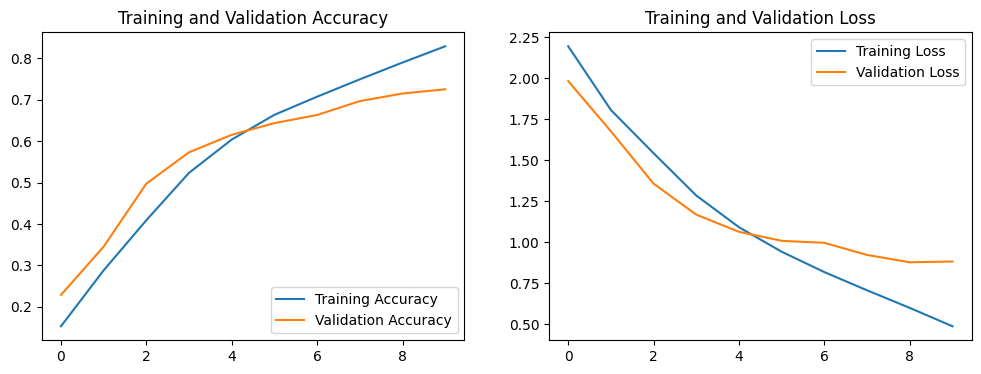

In [11]:
plot_history(history.history)

In [12]:
# save the model and history
VGG11.save('./results/VGG11_cifar10_model.keras')
import pickle
with open('./results/VGG11_cifar10_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)